In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%autoreload
import codebase
from codebase.sparse_regression import *
from codebase.utils import *


categories = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
              'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
              'C7_Restrictions on internal movement', 'C8_International travel controls']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

def events(values, flag=None):
    events = []
    current_value = values[0]
    start = 0
    for i, value in enumerate(values):
        if value != current_value:
            if not flag is None:
                if flag[i-1] == 0:
                    fl = '///'
                else:
                    fl = None
            else:
                fl = None
            events.append((start, i - start, current_value, fl))
            current_value = value
            start = i
    
    
    if not flag is None:
        if flag[i-1] == 0:
            fl = '///'
        else:
            fl = None
    else:
        fl = None
    events.append((start, i - start, current_value, fl))
    return events
            
    
def plot_stringency(df, ax):
    import matplotlib.patches as mpatches
    circ1 = mpatches.Patch( facecolor='white' , hatch=r'///', label='Targeted measures')
    total_length = len(df.index)
    y_ticks = []
    for i, col in enumerate(categories):
        flag_col = col[:3] + 'Flag'
        if flag_col != 'C8_Flag':
            current_events = events(df[[col]].values.flatten(), df[[flag_col]].values.flatten())
        else:
            current_events = events(df[[col]].values.flatten())
        for event in current_events:
            ax.broken_barh([(event[0], event[1])], (10*i, 2*event[2]), facecolors=colors[i], hatch=event[3])
        y_ticks.append(i*10)
    ax.set_ylim(0, 10*(i+1))
    ax.set_xlim(0, total_length)
    ax.set_xlabel('days')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([cat[3:] for cat in categories])
    ax.legend(handles = [circ1],loc=2)
    ax.grid(True)

dataset = CountryDataset()

## Raw stringency

In [6]:
stri_cols = ['C1_School closing', 'C2_Workplace closing', 
             'C3_Cancel public events',
             'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
             'C7_Restrictions on internal movement',
             'C8_International travel controls', 
             # 'C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag'
            ]

cols = {'variables': ['ConfirmedCases'] + stri_cols,
        'time_dependent_variables': ['ConfirmedCases'] + stri_cols,
        'predicted_variables': ['ConfirmedCases'],
        'max_degree': 3}

In [7]:

def plot_measures(country):
    country_data = dataset.ox_for(country, rescaling=1)
    f, ax1 = plt.subplots()
    ax1.set_title(country)
    ax2 = ax1.twinx()
    plot_stringency(country_data, ax1)
    ax2.plot(list(country_data['ConfirmedCases']), 'k.')
    plt.show()
    
a = widgets.interact(plot_measures, country=dataset.all_ox_countries())

interactive(children=(Dropdown(description='country', options=(0, 'Aruba', 'Afghanistan', 'Angola', 'Albania',…

In [19]:
country = "France"

m2, m1 = make_targets_df(dataset.ox_for(country, rescaling=-1))

augmented, integration_args = make_polynomials_df(m1, **cols)

weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=10)
# integration_args['weights'] = weights
# weights


[]

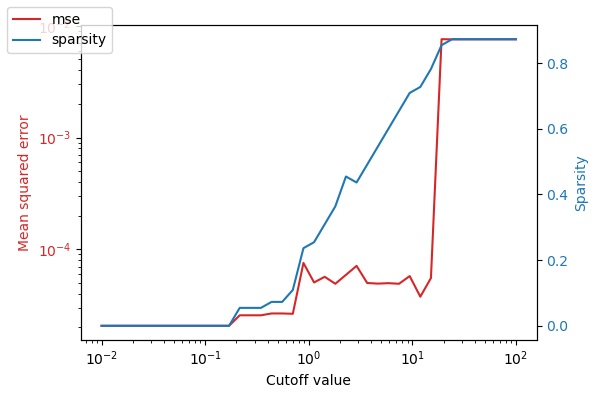

In [26]:
%autoreload

rest = cutoff_mses(augmented, m2[cols['predicted_variables']].values, -2, 2)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(rest['cutoffs'], rest['mses'], color=color, label='mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(rest['cutoffs'], rest['sparsity'], color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()

<div class="alert alert-block alert-danger">
<b>Attention:</b> La cell suivante prend 10 minutes a s'executer.
</div>

In [22]:
cutoff = 1e-10



result = {}

for country in tqdm(dataset.all_ox_countries(), ncols=50):
    all_mses = []
    data = dataset.ox_for(country, rescaling=-1)
    for shift in range(20):

        tmp = data.copy()
        tmp[stri_cols] = tmp[stri_cols].shift(periods=shift)
        tmp = tmp.dropna()
        m2, m1 = make_targets_df(tmp)
        augmented, integration_args = make_polynomials_df(m1, **cols)
        weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=cutoff)
        mse = ((tf.matmul(tf.cast(augmented, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[cols['predicted_variables']].values)**2).numpy().mean()

        all_mses.append(mse)
    result[country] = all_mses




  0%|                     | 0/169 [00:00<?, ?it/s]<ipython-input-22-1a02fadf5293>:18: RuntimeWarning:

Mean of empty slice.

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in true_divide

100%|███████████| 169/169 [09:19<00:00,  3.31s/it]


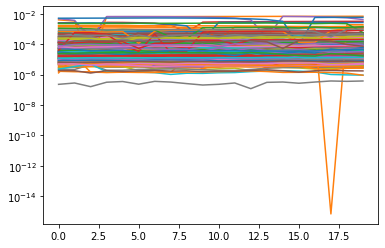

In [27]:
for country, vals in result.items():
    plt.plot(vals)
plt.yscale('log')
plt.show()

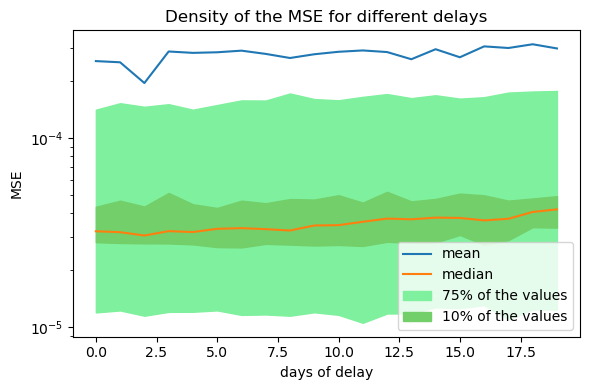

In [58]:
all_values = np.array([vals for vals in result.values()])


mean = np.nanmean(all_values, axis=0)
var = np.nanvar(all_values, axis=0)

plt.figure(dpi=100)
plt.plot(np.nanmean(all_values, axis=0), label='mean')
plt.plot(np.nanquantile(all_values, 0.5, axis=0), label='median')
plt.fill_between(range(len(mean)), 
                 np.nanquantile(all_values, 0.75, axis=0), 
                 np.nanquantile(all_values, 0.25, axis=0), 
                 color='#7ff09d', label='75% of the values')
plt.fill_between(range(len(mean)), 
                 np.nanquantile(all_values, 0.55, axis=0), 
                 np.nanquantile(all_values, 0.45, axis=0), 
                 color='#72cf69', label='10% of the values')
plt.yscale('log')
plt.legend(loc='lower right')
plt.title('Density of the MSE for different delays')
plt.xlabel('days of delay')
plt.ylabel('MSE')
plt.tight_layout()
plt.show()
# plt.savefig('mse_vs_delay.svg', format='svg')

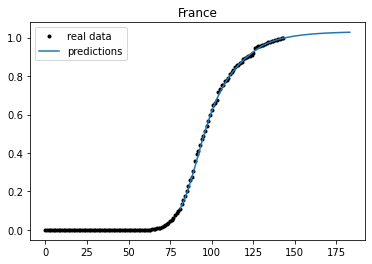

In [68]:
country_data = m1
t = range(len(country_data.index) + (extrapolation:=40))
high_data = country_data[country_data['ConfirmedCases'] > 0.1]
real_t = len(high_data.index)
guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **cols, weights=all_weights[0])
plt.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
plt.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
plt.legend()
plt.title(country)
plt.show()
